In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

pd.options.display.max_columns = None

In [2]:
def data_cleaning(df):
    #Making a copy of the dataset
    df = df.copy()

    #Using CustomerID as index
    df.set_index("CustomerID", inplace=True)

    #Fixing Total Charges column - inserting zeroes for blank columns and casting to float
    df["Total Charges"] = df["Total Charges"].str.replace(" ", "0")
    df = df.astype({"Total Charges": float})

    #Dropping unnecessary columns
    df.drop(columns=["Count", "Country", "State", "City", "Zip Code", "Lat Long", "Churn Label", "Churn Reason"], inplace=True)

    #Mapping columns to numeric values
    #General case, where values are "yes" and "no". Results like "no phone service" are mapped to 0 since the lack of phone service is contained in a different column
    general_mapper = {"No":0, "Yes":1, "No phone service": 0, "No internet service": 0}
    for col in df.columns:
        if "No" in df[col].unique() and "Yes" in df[col].unique():
            df[col] = df[col].map(general_mapper)
    
    #Mapping male to 0 and female to 1
    gender_mapper = {"Male":0, "Female":1}
    df["Gender"] = df["Gender"].map(gender_mapper)

    #Mapping contract lengths into a value representing the length of the contract term in years
    contract_mapper = {"Month-to-month": 1/12, "Two year": 2, "One year":1}
    df["Contract"] = df["Contract"].map(contract_mapper)

    return df

In [3]:
df = pd.read_csv("../swan_data.csv")

In [4]:
df = data_cleaning(df)

In [5]:
def feature_engineering(df):
    # OHE Payment Method and Internet Service columns
    df = pd.get_dummies(df, 
                        columns = ['Payment Method', 'Internet Service'], 
                        prefix = ['pay','is'], 
                        drop_first = True, 
                        dtype = int)
        
    return df

In [6]:
df = feature_engineering(df)

In [7]:
features = ['Gender', 'Senior Citizen', 'Partner',
       'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Monthly Charges', 'Total Charges',
       'pay_Credit card (automatic)', 'pay_Electronic check',
       'pay_Mailed check', 'is_Fiber optic', 'is_No']

In [8]:
X = df[features]
y = df["Churn Value"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [10]:
clf = RandomForestClassifier()

In [11]:
rf_params = {
    'class_weight':['balanced'],
    'criterion':['entropy'],
    'n_estimators': [100, 150, 200],
    'max_depth': [6, 8, 10, 12],
}

gs = GridSearchCV(clf, param_grid=rf_params, cv=5, verbose=3, scoring='recall')

In [12]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=100;, score=0.747 total time=   2.3s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=100;, score=0.809 total time=   2.2s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=100;, score=0.747 total time=   2.1s
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=100;, score=0.849 total time=   2.3s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=100;, score=0.828 total time=   2.1s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=150;, score=0.743 total time=   3.7s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=150;, score=0.826 total time=   4.1s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=150;, score=0.773 total time=   

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [6, 8, 10, 12],
                         'n_estimators': [100, 150, 200]},
             scoring='recall', verbose=3)

In [22]:
gs.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 6,
 'n_estimators': 200}

In [13]:
def apr(y_pred, y_real):
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1

In [14]:
y_pred = gs.predict(X_train)
apr(y_pred, y_train)

Accuracy:0.7802626908058218
Precision:0.5620857269111799
Recall:0.837393021724819
F1:0.6726599682707562


(0.7802626908058218, 0.5620857269111799, 0.837393021724819, 0.6726599682707562)

In [15]:
y_test_pred = gs.predict(X_test)
apr(y_test_pred, y_test)

Accuracy:0.7544357700496807
Precision:0.5036764705882353
Recall:0.7828571428571428
F1:0.6129753914988815


(0.7544357700496807,
 0.5036764705882353,
 0.7828571428571428,
 0.6129753914988815)

In [16]:
train_results = X_train.copy()
train_results["Churn Probability"] = gs.predict_proba(X_train)[:,1]
train_results["Churn Value"] = y_train

test_results = X_test.copy()
test_results["Churn Probability"] = gs.predict_proba(X_test)[:,1]
test_results["Churn Value"] = y_test

results = pd.concat([train_results, test_results])

In [17]:
top_500 = results[results['Churn Value'] == 0].sort_values('Churn Probability', ascending=False)["Churn Probability"].iloc[:500]

In [18]:
top_500.to_csv("RandomForest_500.csv")

In [19]:
results[results['Churn Value'] == 0]["Churn Probability"].to_csv("RF_churn_risk.csv")

In [20]:
importances = gs.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in gs.best_estimator_.estimators_], axis=0)


<Figure size 10000x80000 with 0 Axes>

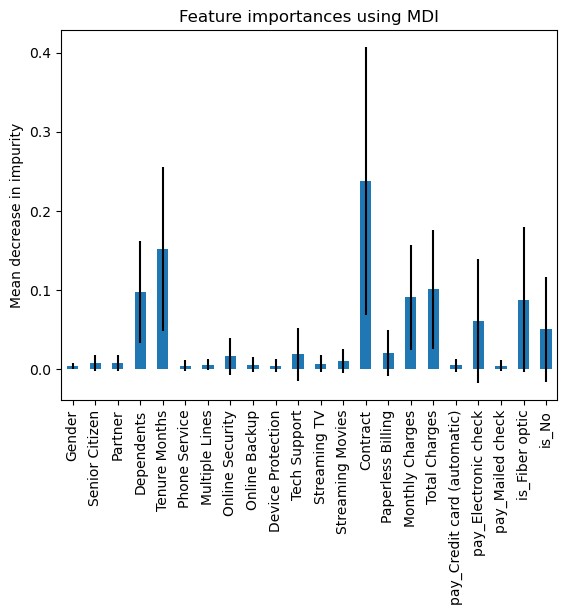

In [21]:
forest_importances = pd.Series(importances, index=list(X_train.columns))

plt.figure(figsize=(100,800))
fig, ax = plt.subplots()

forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()
plt.show()